In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('AirQualityUCI.csv', header=0, sep=';')

In [3]:
raw_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [4]:
data = raw_data[[col for col in raw_data.columns if 'Unnamed' not in col]].dropna()
data['datetime'] = data['Date'] + ' ' + data['Time'].apply(lambda line: line.replace('.', ':'))
data.drop(['Date', 'Time'], inplace=True, axis=1)
data['datetime'] = pd.to_datetime(data['datetime'])

In [5]:
for col in data.columns:
    if col != 'datetime' and 'float' not in str(data[col].dtype):
        data[col] = data[col].apply(lambda value: value.replace(',', '.'))
        data[col] = data[col].astype('double')

In [6]:
data = data.replace({-200.0: np.nan})

In [7]:
data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'datetime'],
      dtype='object')

In [8]:
for chem in ['CO', 'NMHC', 'C6H6', 'NO2', 'O3', 'NOx']:
    for col in data.columns:
        if col.startswith(chem):
            data.rename(columns={col: chem}, inplace=True)
        elif chem in col:
            data.rename(columns={col: 'sensor_{}'.format(chem)}, inplace=True)

In [9]:
data.isna().sum()

CO             1683
sensor_CO       366
NMHC           8443
C6H6            366
sensor_NMHC     366
NOx            1639
sensor_NOx      366
NO2            1642
sensor_NO2      366
sensor_O3       366
T               366
RH              366
AH              366
datetime          0
dtype: int64

In [10]:
data.drop('NMHC', inplace=True, axis=1)

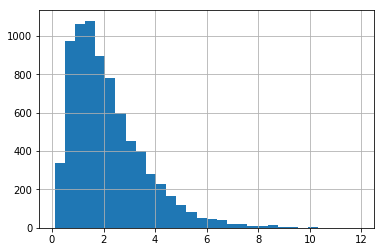

In [11]:
data.CO.hist(bins=30)

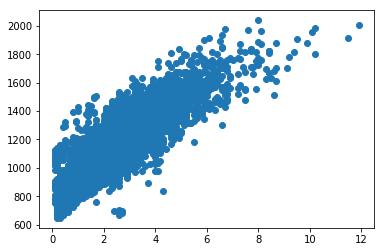

In [12]:
plt.scatter(data['CO'], data['sensor_CO'])

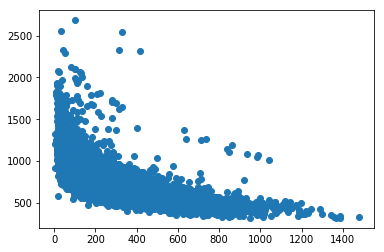

In [13]:
plt.scatter(data['NOx'], data['sensor_NOx'])

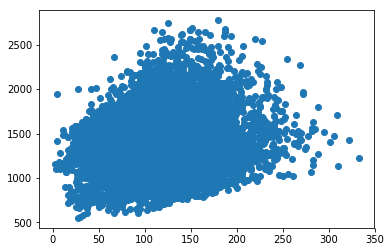

In [14]:
plt.scatter(data['NO2'], data['sensor_NO2'])

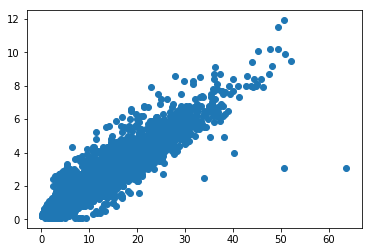

In [17]:
plt.scatter(data['C6H6'], data['CO'])

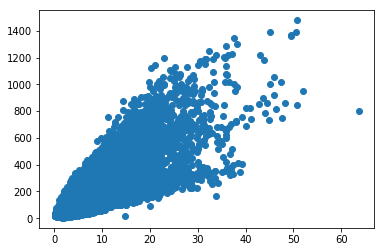

In [19]:
plt.scatter(data['C6H6'], data['NOx'])

In [23]:
data = data.sort_values('datetime')

In [29]:
data.drop('hour', inplace=True, axis=1)

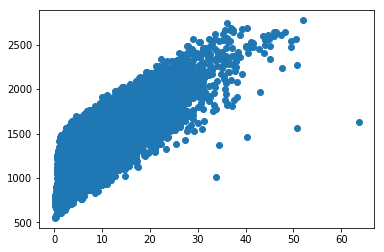

In [41]:
plt.scatter(data['C6H6'], data['sensor_NO2'])

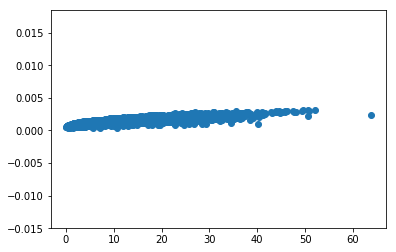

In [45]:
plt.scatter(data['C6H6'], 1 / data['sensor_NOx'])

**Modelling**

SyntaxError: invalid syntax (<ipython-input-53-5702ae874596>, line 1)